*- Computer Vision*
```
Ophelia DANKYI
```



WHY KERAS?

Keras is well-suited for CIFAR-10 classification due to its simple API for defining convolutional neural networks (CNNs). It supports fast testing and training, with built-in optimizations like XLA and GPU acceleration. Pre-trained models like ResNet50 can be easily fine-tuned for CIFAR-10, and TensorBoard integration allows real-time monitoring of training metrics. Keras also simplifies model deployment to platforms like TensorFlow Lite for mobile devices.


# 0. Setup and Preprocessing of the CIFAR-10 Dataset

## 0.1: Load the necessary libraries

In [18]:
# Load necessary libraries for the first part of this assignment
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from tensorflow.keras import Sequential
import scipy.misc
from keras.optimizers import Adam
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from tensorflow.keras.datasets import cifar10
from collections import Counter

import seaborn as sns
import pandas as pd
import numpy as np
import random
import time

from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping, Callback

from collections import Counter
import cv2

## 0.2: Load the CIFAR-10 Dataset and Splitting

In [19]:
# Load the CIFAR-10 dtaset, normalise pixel values and convert labels to one-hot encoding
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Split the training set into training and validation sets (80/20 split)
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


## 0.3 Plots Avenue

In [3]:

# Plot loss and accuracy
def plot_loss_and_accuracy(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss During Training')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history.get('accuracy', []), label='Training Accuracy', linewidth=2)
    ax2.plot(history.history.get('val_accuracy', []), label='Validation Accuracy', linewidth=2)
    ax2.set_title('Model Accuracy During Training')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# Plot comparison of multiple histories
def plot_multiple_histories(histories, model_infos):
    fig, axes = plt.subplots(2, len(histories), figsize=(15, 10))
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

    for i, (history, info) in enumerate(zip(histories, model_infos)):
        color = colors[i % len(colors)]

        # Plot Loss
        ax_loss = axes[0, i]
        ax_loss.plot(history.history['loss'], label='Training Loss', color=color, linewidth=2)
        ax_loss.plot(history.history['val_loss'], '--', label='Validation Loss', color=color, linewidth=2)
        ax_loss.set_title(f'{info} Loss')
        ax_loss.set_xlabel('Epochs')
        ax_loss.set_ylabel('Loss')
        ax_loss.legend()
        ax_loss.grid(True)

        # Plot Accuracy
        ax_acc = axes[1, i]
        ax_acc.plot(history.history.get('accuracy', []), label='Training Accuracy', color=color, linewidth=2)
        ax_acc.plot(history.history.get('val_accuracy', []), '--', label='Validation Accuracy', color=color, linewidth=2)
        ax_acc.set_title(f'{info} Accuracy')
        ax_acc.set_xlabel('Epochs')
        ax_acc.set_ylabel('Accuracy')
        ax_acc.legend()
        ax_acc.grid(True)

    plt.tight_layout()
    plt.show()

# Visualize CIFAR-10 class distribution
def visualize_distribution(x, y):
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    class_counts = Counter(y.flatten())

    plt.figure(figsize=(6, 4))
    plt.bar(class_names, [class_counts[i] for i in range(len(class_names))])
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution in CIFAR-10 Training Set')
    plt.xticks(rotation=45)
    plt.show()

# Callback to compute training time
class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.times = []
        self.train_start_time = time.time()

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.times.append(time.time() - self.epoch_start_time)

    def on_train_end(self, logs=None):
        self.total_train_time = time.time() - self.train_start_time
        print(f'Total training time: {self.total_train_time:.2f} seconds')

# Preprocess input image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet.preprocess_input(img_array)
    return img_array

# Get top 3 predictions for an image
def get_top_classes(model, img_array):
    preds = model.predict(img_array)
    decoded_preds = tf.keras.applications.mobilenet.decode_predictions(preds, top=3)[0]
    return [(pred[1], pred[2]) for pred in decoded_preds], preds

# Generate saliency map by occluding parts of the image
def generate_saliency_map(model, img_array, correct_class_idx, square_size=50):
    saliency_map = np.zeros((224, 224))
    for i in range(0, 224, 5):
        for j in range(0, 224, 5):
            occluded_img = img_array.copy()
            occluded_img[:, i:i+square_size, j:j+square_size, :] = 0
            preds = model.predict(occluded_img)
            saliency_map[i:i+square_size, j:j+square_size] = preds[0, correct_class_idx]
    return saliency_map

# Visualize original image and corresponding saliency map
def transformation(model, img_path):
    original_images, saliency_maps, top_classes = [], [], []
    for i in range(3):
        img_file = f'{img_path}_occ_{i+1}.jpg'
        img_array = preprocess_image(img_file)

        top_classes, preds = get_top_classes(model, img_array)
        correct_class_idx = np.argmax(preds[0])

        saliency_map = generate_saliency_map(model, img_array, correct_class_idx)

        original_img = image.load_img(img_file, target_size=(224, 224))
        original_images.append(original_img)
        saliency_maps.append(saliency_map)

    return original_images, saliency_maps, top_classes


# Question 1:  Building the CNN Model

## 1.1: The Basic CNN

The basic CNN model below begins with a Conv2D layer of 32 filters (3x3 kernel, ReLU activation) to extract features from the CIFAR-10 images (input shape: 32x32x3). A MaxPooling2D layer (2x2) reduces the spatial dimensions. The process is repeated with two Conv2D layers of 64 filters each, interspersed with another pooling layer. The output is then flattened and passed through a Dense layer of 64 units (ReLU activation) before the final Dense layer of 10 units (softmax activation) for classifying the images into the 10 CIFAR-10 classes.

This structure is a basic CNN, and it is effective for small image classification tasks.

In [4]:
model0 = Sequential()
model0.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3))),
model0.add(layers.MaxPooling2D((2, 2))),
model0.add(layers.Conv2D(64, (3, 3), activation='relu')),
model0.add(layers.MaxPooling2D((2, 2))),
model0.add(layers.Conv2D(64, (3, 3), activation='relu')),
model0.add(layers.Flatten()),
model0.add(layers.Dense(64, activation='relu')),
model0.add(layers.Dense(10, activation='softmax'))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
model0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model0.compile(optimizer = Adam(), metrics = ['accuracy'], loss = 'categorical_crossentropy' )

### 1.1.1: Training

In [7]:
history0 = model0.fit(x_train, y_train, epochs = 70 , batch_size = 100,
                    validation_data=(x_val, y_val))

Epoch 1/70


I0000 00:00:1728754370.889771     100 service.cc:145] XLA service 0x7ae804004a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728754370.889818     100 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728754370.889822     100 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 46/400 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1561 - loss: 2.2327

I0000 00:00:1728754373.713263     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


400/400 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.3055 - loss: 1.8816 - val_accuracy: 0.4969 - val_loss: 1.3950
Epoch 2/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5163 - loss: 1.3440 - val_accuracy: 0.5281 - val_loss: 1.3063
Epoch 3/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5699 - loss: 1.2042 - val_accuracy: 0.5840 - val_loss: 1.1548
Epoch 4/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6105 - loss: 1.1003 - val_accuracy: 0.6080 - val_loss: 1.0974
Epoch 5/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6457 - loss: 0.9986 - val_accuracy: 0.6465 - val_loss: 1.0031
Epoch 6/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6700 - loss: 0.9427 - val_accuracy: 0.6497 - val_loss: 0.9999
Epoch 7/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6949 - loss: 0.8843 - val_accuracy: 0.6653 - val_loss: 0.9539
Epoch 8/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7146 - loss: 0.8254 - val_accuracy: 0.6754 - val_

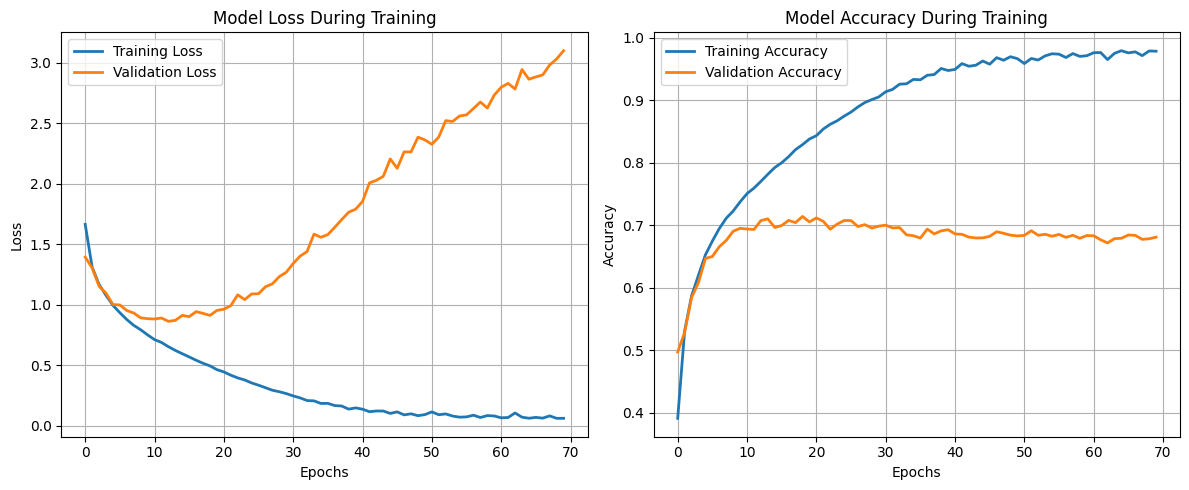

In [8]:
plot_loss_and_accuracy(history0)

### 1.1.2: Evaluation

In [9]:
model0.evaluate(x_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6805 - loss: 3.1035


[3.142380714416504, 0.6779999732971191]

### 1.1.3: Obesrvation and Comments

The model's evaluation on the test data confirms overfitting: it achieves a test accuracy of 66.36% and a high test loss of 3.21, indicating poor performance on unseen data compared to the high training accuracy (~98%). To improve test performance and generalization, data augmentation, regularization (like dropout or L2), and early stopping can be considered to prevent the model from overfitting to the training data

## 1.2: 2nd CNN model from scratch

This model expands upon the basic CNN by introducing several key modifications aimed at improving performance and generalization. 
**Batch Normalization:**
Added after each Conv2D and dense layer to stabilize and speed up training. This improves training stability and speeds up convergence.

**Dropout:** 
Added after the second Conv2D block (0.25) and dense layer (0.2) to prevent overfitting.

**Increased Filters:** 
Introduced a third Conv2D block with 128 filters (more capacity for feature extraction).

**Increased Dense Layer Units:**
Increased from 64 to 128 units in the dense layer to enhance learning capacity.

In [10]:
def build_cnn_model_scratch():
    model1 = Sequential()
    # First Conv Block
    model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D((2, 2)))


    # Second Conv Block
    model1.add(Conv2D(64, (3, 3), activation='relu'))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D((2, 2)))
    model1.add(Dropout(0.25))

    # Third Conv Block
    model1.add(Conv2D(128, (3, 3), activation='relu'))
    model1.add(BatchNormalization())
    model1.add(MaxPooling2D((2, 2)))


    # Flatten and Dense Layers
    model1.add(Flatten())
    model1.add(Dense(128, activation='relu'))
    model1.add(BatchNormalization())
    model1.add(Dropout(0.2))
    model1.add(Dense(10, activation='softmax'))

    return model1

model1 = build_cnn_model_scratch()
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 161,610 (631.29 KB)

 Trainable params: 160,906 (628.54 KB)

 Non-trainable params: 704 (2.75 KB)

### 1.2.2: Training the 2nd model

In [12]:
history1 = model1.fit(x_train, y_train, epochs = 70, batch_size = 100,
                    validation_data=(x_val, y_val))

Epoch 1/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.3841 - loss: 1.8112 - val_accuracy: 0.2357 - val_loss: 2.1421
Epoch 2/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5830 - loss: 1.1690 - val_accuracy: 0.5270 - val_loss: 1.3737
Epoch 3/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6536 - loss: 0.9900 - val_accuracy: 0.6283 - val_loss: 1.0763
Epoch 4/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6879 - loss: 0.8845 - val_accuracy: 0.6681 - val_loss: 0.9557
Epoch 5/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7224 - loss: 0.7969 - val_accuracy: 0.6981 - val_loss: 0.8674
Epoch 6/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7431 - loss: 0.7350 - val_accuracy: 0.6901 - val_loss: 0.8905
Epoch 7/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7633 - loss: 0.6754 - val_accuracy: 0.6683 - val_loss: 0.9790
Epoch 8/70
400/400 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7750 - loss: 0.6466 - val_accuracy: 0

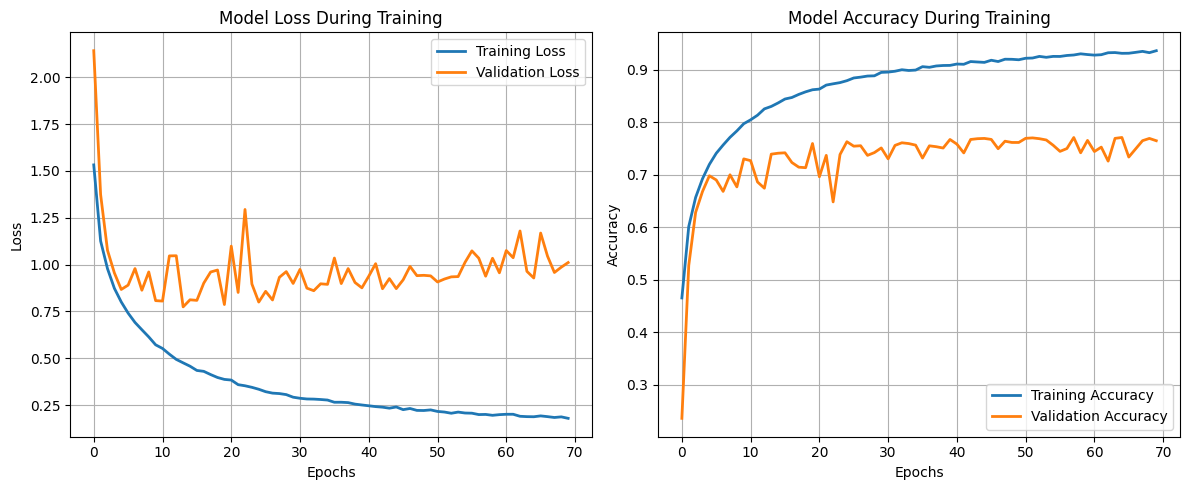

In [13]:
plot_loss_and_accuracy(history1)

### 1.2.3: Evaluating the 2nd model

In [14]:
# Evaluate the model on the test data
test_loss, test_accuracy = model1.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_accuracy:.4f}")

313/313 - 2s - 5ms/step - accuracy: 0.7589 - loss: 1.0259
Test accuracy: 0.7589


### 1.2.3: Observation and comments

This second model shows a clear improvement: test accuracy increased from 66.36% to 76.17%, and validation loss decreased significantly (from ~3.21 to ~1.02). The addition of Batch Normalization and Dropout reduced overfitting, as shown by the smaller gap between training and validation accuracy.

To improve further , this is what can be done:

1. Increase Dropout to reduce overfitting more.
2. Use a learning rate scheduler for better convergence.
3. Apply data augmentation to improve generalization.
4. Implement early stopping to prevent unnecessary overfitting.

## 1.3: 3rd CNN model from scratch

These are the specific changes made to the second model and the reasons:

**Extra Conv2D Layers:** 
Each block now has two Conv2D layers instead of one to extract more complex features at each stage for improved feature representation.

**Increased Dropout Rates:** 
Dropout is increased to 0.3, 0.4, and 0.5 to reduce overfitting by preventing the model from relying too heavily on specific neurons.

**Larger Dense Layer:**
The dense layer size increased from 128 to 256 units to give the model more capacity for learning complex patterns.

**'Same' Padding:** 
All Conv2D layers use 'same' padding to preserve spatial dimensions, which helps retain image features across layers.

**More Batch Normalization:**
Applied after every Conv2D layer for consistent activation normalization, improving training stability and convergence.

In [15]:
from tensorflow.keras import models, layers

def second_cnn_model_scratch():
    model2 = models.Sequential()

    # First Conv Block
    model2.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.MaxPooling2D((2, 2)))
    model2.add(layers.Dropout(0.3))  # Increased dropout for regularization

    # Second Conv Block
    model2.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.MaxPooling2D((2, 2)))
    model2.add(layers.Dropout(0.4))  # Increased dropout to further prevent overfitting

    # Third Conv Block
    model2.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.MaxPooling2D((2, 2)))
    model2.add(layers.Dropout(0.5))  # Higher dropout to ensure model generalization

    # Flatten and Dense Layers
    model2.add(layers.Flatten())
    model2.add(layers.Dense(256, activation='relu'))
    model2.add(layers.BatchNormalization())
    model2.add(layers.Dropout(0.5))  # Strong dropout for dense layers
    model2.add(layers.Dense(10, activation='softmax'))  # Output for CIFAR-10 classes

    return model2

model2 = second_cnn_model_scratch()
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [16]:
model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 816,938 (3.12 MB)

 Trainable params: 815,530 (3.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

### 1.3.1: Training

In [17]:
# Train the 2nd model
history2= model2.fit(x_train, y_train, epochs= 100 , batch_size = 100,
                    validation_data=(x_val, y_val))

Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.3052 - loss: 2.3217 - val_accuracy: 0.2621 - val_loss: 2.3356
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5187 - loss: 1.3494 - val_accuracy: 0.4644 - val_loss: 1.5937
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6094 - loss: 1.0986 - val_accuracy: 0.6059 - val_loss: 1.1245
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6657 - loss: 0.9454 - val_accuracy: 0.7015 - val_loss: 0.8492
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6929 - loss: 0.8657 - val_accuracy: 0.6891 - val_loss: 0.8974
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7206 - loss: 0.8017 - val_accuracy: 0.7358 - val_loss: 0.7541
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7317 - loss: 0.7583 - val_accuracy: 0.7409 - val_loss: 0.7222
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.7553 - loss: 0.7000 -

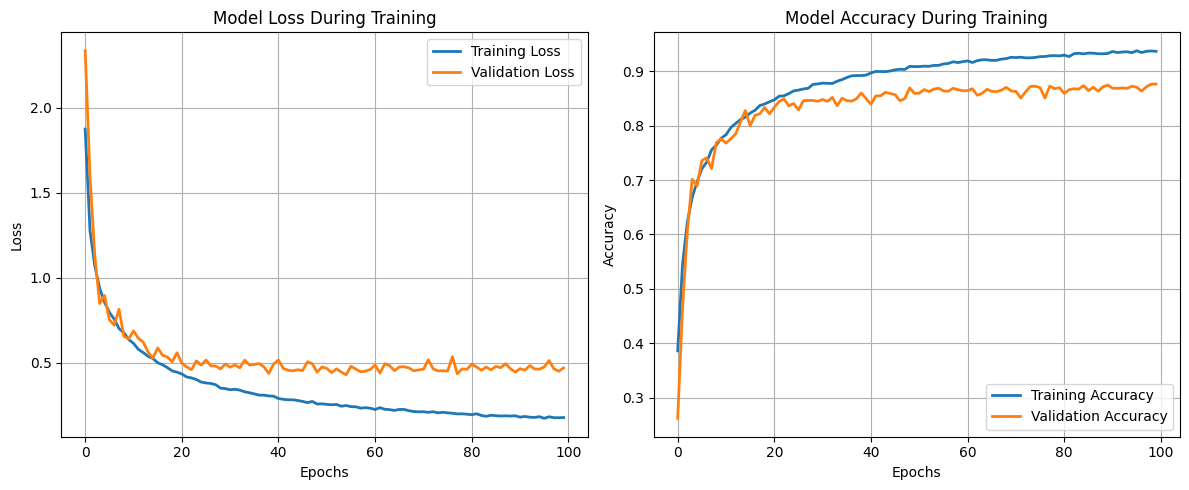

In [18]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_loss_and_accuracy(history2)


### 1.3.2: Evaluation

In [19]:
# Evaluate the model on the test data
test_loss, test_accuracy = model2.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_accuracy:.4f}")

313/313 - 3s - 9ms/step - accuracy: 0.8707 - loss: 0.4706
Test accuracy: 0.8707


### 1.3.3: Observation and comments

**Oservation**
Test Accuracy improved to 86.69%, up from 76.17% in the second model, indicating better generalization.

Overfitting reduced: Validation accuracy (approximately 87%) is much closer to training accuracy (approximately 94%), thanks to increased dropout and more Conv2D layers.

Validation loss decreased to 0.49, showing improved model generalization.

Consider increasing dropout or adding L2 regularization to reduce overfitting. Apply data augmentation and use a learning rate scheduler for better generalization and convergence. Implement early stopping and tune hyperparameters for further impro



### 1.3.4: Review

 NOTE: A large number of epochs of 70 was used in all three models to achieve their respective results.
 
Overall, each model progressively improved in complexity and regularization, leading to better performance on the CIFAR-10 dataset, with the third model showing the best balance between training accuracy and generalization. I would have liked to experiment further by adding **early stopping** to prevent overfitting, implementing a **learning rate scheduler** to dynamically adjust the learning rate during training, and using **data augmentation** to increase the diversity of training data. However, due to time constraints and the need to submit my assignment on time, I could not explore these options. I believe incorporating these techniques would have further improved the model’s performance.

### 1.4.3: Observation and Comments

In [20]:
# ###   early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=1, verbose=1, factor=0.5, min_lr=0.00001)

# Comparing and selecting the best model

# Question 2: Classification with Transfer Learning

### WHY RestNet50 for CIFAR-10?

I chose ResNet50 for CIFAR-10 because its deep architecture with skip connections allows it to extract more complex features and outperform models like VGG16. It also uses fewer parameters, making it more efficient. While I struggled with resizing the CIFAR-10 images from 32x32 to 224x224, the improved generalization from transfer learning and overall better performance made it worth the effort.


#### *In transfer learning with ResNet50, the CIFAR-10 images (32x32) are resized to 224x224 to match the input size expected by ResNet50, which was trained on ImageNet. This resizing ensures compatibility between the CIFAR-10 dataset and ResNet50, allowing the model to utilize its pre-trained features effectivel*

Firstly, an environment is set up to use ResNet50, a pre-trained deep learning model, as the base for image classification for the CIFAR-10.

### 2.1: Set up

In [20]:
from keras.applications.resnet50 import ResNet50
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Dense, Flatten, Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical


#### 2.1.1: Load the CIFAR- 10 Data, normalse and split

In [21]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0


In [22]:
# Normalize pixel values to be between 0 and 1
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#### 2.1.3: Load ResNet50 pre-trained model and freeze its layers

**include_top = False**  lets you use ResNet50's learned features while allowing you to add your own layers for specific tasks like CIFAR-10 classification, making it easier to adapt the model for new tasks through transfer learning.

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

base_model = tf.keras.applications.ResNet50(
    weights ='imagenet',         
    input_shape = (224, 224, 3),
    include_top= False  ) 

# Freeze the pre-trained layers (so they don't get updated during training)
base_model.trainable = False

# # Freeze the pre-trained layers (so they don't get updated during training)
# base_model.trainable = True

# # Create a new model on top of ResNet50
# modeltransfer = models.Sequential([
#     base_model,  
#     layers.GlobalAveragePooling2D(), 
#     layers.Dense(1024, activation='relu'), 
#     layers.Dropout(0.5),  
#     layers.Dense(10, activation='softmax')  
# ])



### 2.2: Building a new model on top of RestNet

The cell below defines a Sequential model that adds custom layers on top of the frozen ResNet50 base.
It adds GlobalAveragePooling2D layer, a Dense layer with 1024 units, a Dropout layer (0.5) to prevent overfitting, and a Dense output layer with 10 units for CIFAR-10 class predictions using softmax.

#### 2.2.1: The Sequential Model 

In [24]:
# Create a new model on top of ResNet50
modeltransfer = models.Sequential([
    base_model,  
    layers.GlobalAveragePooling2D(), 
    layers.Dense(1024, activation='relu'), 
    layers.Dropout(0.5),  
    layers.Dense(10, activation='softmax')  
])

Compiling the model and setting it up for training

In [25]:
modeltransfer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### 2.2.2: Preprocessing Function

The preprocess function resizes CIFAR-10 images from 32x32 to 224x224 to match ResNet50’s input size and normalizes them using ResNet50’s preprocessing standards. This ensures compatibility with the model and optimizes its feature extraction.



In [26]:
# Preprocess CIFAR-10 images for ResNet50 (resize and normalize)
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.resnet.preprocess_input(image)  
    return image, label

#### 2.2.3: Creating Training and Test Datasets

In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(preprocess).batch(16).shuffle(1000).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.map(preprocess).batch(16).prefetch(tf.data.AUTOTUNE)


#### 2.2.4: Training the new layers

In [28]:
historytransfer = modeltransfer.fit(train_dataset, epochs=1, validation_data=test_dataset)

I0000 00:00:1728758933.770873    4344 service.cc:145] XLA service 0x7f837804b450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728758933.770933    4344 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728758933.770939    4344 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   4/3125 ━━━━━━━━━━━━━━━━━━━━ 2:26 47ms/step - accuracy: 0.0911 - loss: 2.9959  

I0000 00:00:1728758940.615936    4344 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 205s 54ms/step - accuracy: 0.7833 - loss: 0.6380 - val_accuracy: 0.8935 - val_loss: 0.3088


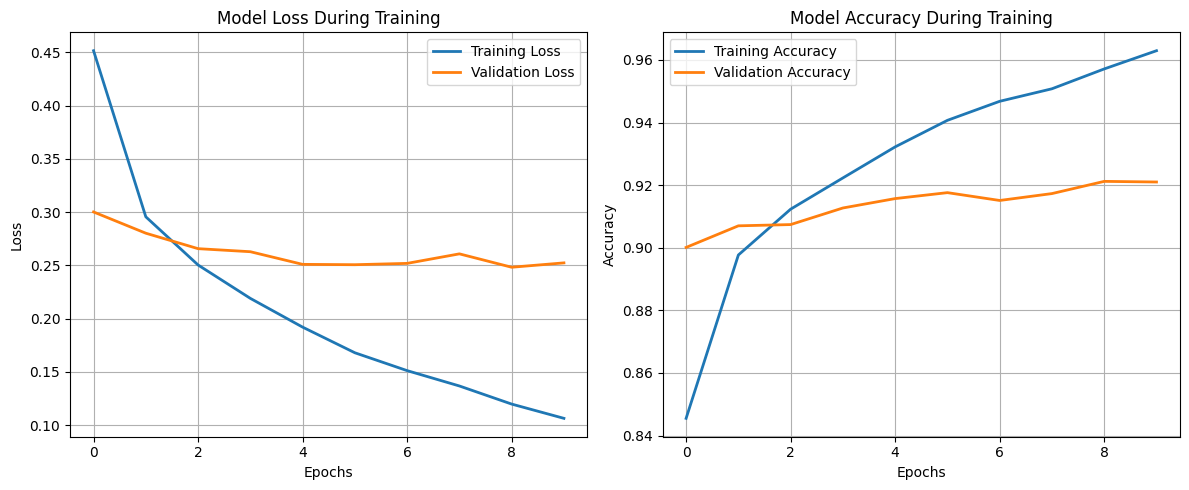

In [31]:
plot_loss_and_accuracy(historytransfer)

#### 2.2.5 Observation and evaluation

I ran 10 epochs to get this result but becuase of GPU issues and the crashing og my ram I had to rerun. Unfortunaly, I could not complete the process before the deadline. But the the evalation on the test was 90% and and so in comparison, transfer learning uses a great deal of time than the previous built models. This is so because these Image Net models are heavily built with lots of parameters.

In [38]:
test_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.uint8, name=None))>

In [43]:
# Evaluate modeltransfer on the test data
modeltransfer.evaluate(test_dataset)


625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.1191 - loss: 2.7055


[2.6996264457702637, 0.1234000027179718]

### 2.3: Fine-tuning

#### 2.3.1 Unfreeze and Compile

In [ ]:
# Unfreeze the base_model for fine-tuning (transfer learning stage 2)
base_model.trainable = True

# Recompile with a lower learning rate for fine-tuning
modeltransfer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



#### 2.3.2: Training for fine-tuning

In [ ]:
# Continue training for fine-tuning
fine_tune_history = modeltransfer.fit(train_dataset, epochs=10, validation_data=test_dataset)


In [ ]:
historyfreeze = modeltransfer.fit(train_dataset, epochs=2, validation_data=test_dataset)


In [ ]:
# Example of how to use train_dataset and test_dataset with model.fit()
# model.fit(train_dataset, validation_data=test_dataset, epochs=10)


In [ ]:
modeltransfer.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])